 # Localization in spectral embeddings

- toc: true,
- badges: true,
- categories: [pedigo, graspologic],
- hide: true,
- search_exclude: true

Trying to replicate results from a forthcoming paper by Alex Hayes + Karl Rohe

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspy.models import SBMEstimator
from graspy.models.sbm import _block_to_full
from graspy.plot import heatmap, pairplot
from graspy.simulations import sbm

sns.set_context("talk")
mpl.rcParams["axes.edgecolor"] = "lightgrey"
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False


def block_heatmap(B, title=""):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    sns.heatmap(B, annot=True, cmap="Reds", cbar=False, square=True, ax=ax)
    ax.set(xlabel="Community", title=title)
    return ax


def make_plot_df(embedding):
    plot_df = pd.DataFrame(
        data=embedding, columns=[str(i) for i in range(embedding.shape[1])]
    )
    plot_df["label"] = labels
    plot_df["degree"] = degrees
    plot_df["neg_degree"] = -degrees
    plot_df.sort_values(["label", "neg_degree"], ascending=True, inplace=True)
    plot_df["ind"] = range(n)
    return plot_df



 ## Setting up the model
 Below are the parameters for a DCSBM (prior to rescaling to set the expected degree)

[Text(0.5, 0, 'log(Degree correction)')]

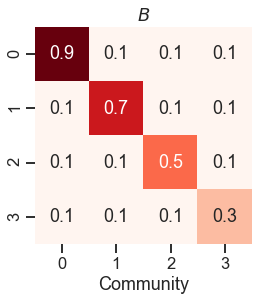

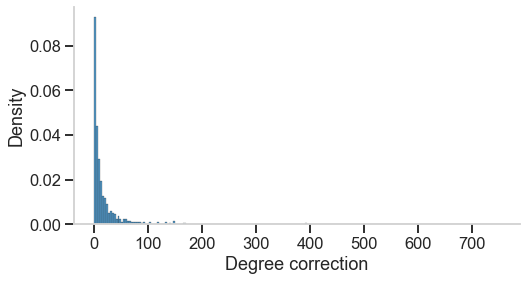

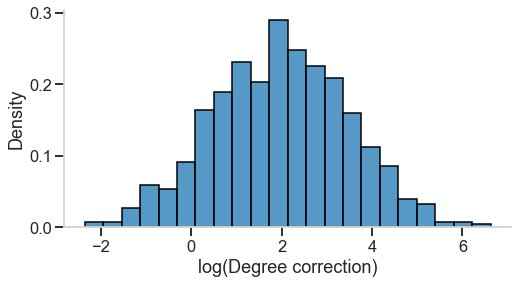

In [2]:
n = 1000
k = 4
expected_degree = 40
degree_corrections = np.random.lognormal(2, 1.5, size=(n))
community_sizes = np.full(k, n // k)
block_probs = np.full((k, k), 0.1)
block_probs[0, 0] = 0.9
block_probs[1, 1] = 0.7
block_probs[2, 2] = 0.5
block_probs[3, 3] = 0.3

block_heatmap(block_probs, title=r"$B$")

_, labels = sbm(
    community_sizes, block_probs, directed=False, loops=False, return_labels=True
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(degree_corrections, ax=ax, stat="density")
ax.set(xlabel="Degree correction")

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(np.log(degree_corrections), ax=ax, stat="density")
ax.set(xlabel="log(Degree correction)")


In [3]:
block_p_mat = _block_to_full(block_probs, labels, (n, n))
unscaled_expected_degree = np.mean(np.sum(block_p_mat, axis=1))
scaling_factor = 40 / unscaled_expected_degree
print(f"Scaling factor: {scaling_factor:.3f}")


Scaling factor: 0.178


 ## Sampling from the model
 Here I just sample a graph from the model (after rescaling to set the expected degree).
 Below I plot the adjacency matrix sorted by block and then by node degree within block.
 I also calculate the mean degree to show that it is close to what we specified.

Mean degree: 40.060


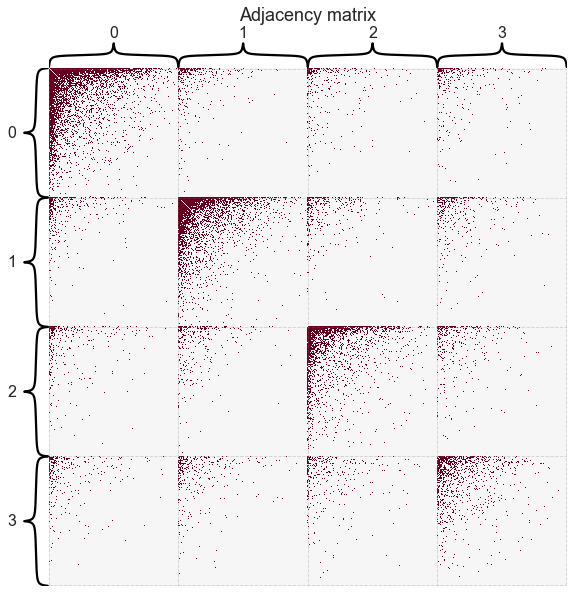

In [4]:
for ul in np.unique(labels):
    dc_sum = degree_corrections[labels == ul].sum()
    degree_corrections[labels == ul] /= dc_sum

adj, labels = sbm(
    community_sizes,
    scaling_factor * block_probs,
    directed=False,
    loops=False,
    dc=degree_corrections,
    return_labels=True,
)
heatmap(
    adj,
    cbar=False,
    title="Adjacency matrix",
    inner_hier_labels=labels,
    sort_nodes=True,
    hier_label_fontsize=16,
)
mean_degree = np.mean(np.sum(adj, axis=0))
print(f"Mean degree: {mean_degree:.3f}")


 ## Double checking the model parameters
 Below is a quick sanity check that the graph we sampled has block probabilities that are
 close to what we set originally if we undo the rescaling step.

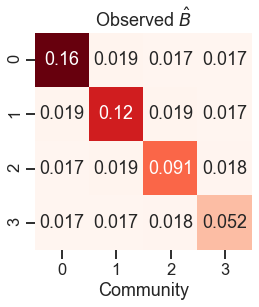

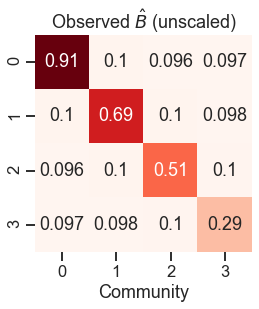

In [5]:
sbme = SBMEstimator(directed=False, loops=False)
sbme.fit(adj, y=labels)
block_p_hat = sbme.block_p_
block_heatmap(block_p_hat, title=r"Observed $\hat{B}$")
block_p_hat_unscaled = block_p_hat * 1 / scaling_factor
block_heatmap(block_p_hat_unscaled, title=r"Observed $\hat{B}$ (unscaled)")


 ## Spectral embedding
 Here I use graspy to do ASE, LSE, and regularized LSE. Note that we're just using the
 SVDs here. There is an option on whether to throw out the first eigenvector.

In [6]:
embed_kws = dict(n_components=k + 1, algorithm="full", check_lcc=False)
ase = AdjacencySpectralEmbed(**embed_kws)
lse = LaplacianSpectralEmbed(form="DAD", **embed_kws)
rlse = LaplacianSpectralEmbed(form="R-DAD", **embed_kws)

ase_embed = ase.fit_transform(adj)
lse_embed = lse.fit_transform(adj)
rlse_embed = rlse.fit_transform(adj)
embeddings_list = [ase_embed, lse_embed, rlse_embed]

remove_first = True
for i, embedding in enumerate(embeddings_list):
    if remove_first:
        embeddings_list[i] = embedding[:, 1:]
    else:
        embeddings_list[i] = embedding[:, :k]


In [7]:
degrees = adj.sum(axis=1)
methods = ["ase", "lse", "rlse"]
embeddings = dict(zip(methods, embeddings_list))
plot_dfs = {}
palette = dict(zip(np.unique(labels), sns.color_palette("deep", 10)))

for method, embedding in embeddings.items():
    plot_df = make_plot_df(embedding)
    plot_dfs[method] = plot_df


 ## Looking at the spectral embeddings
 In the next few cells, I plot
 - Pairplots
 - Individual eigenvectors, sorted by block and then by node degree w/in block
 - Eigenvector values for each node plotted agains node degree

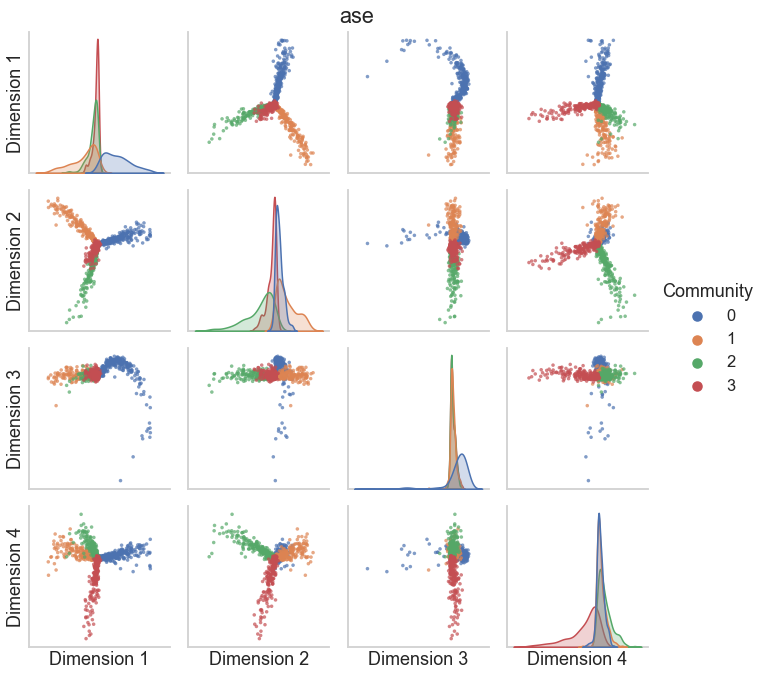

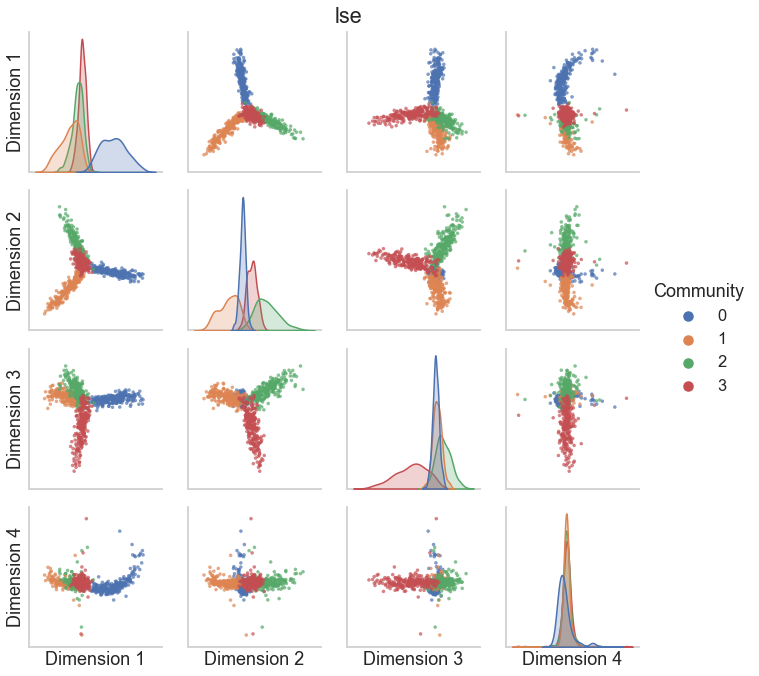

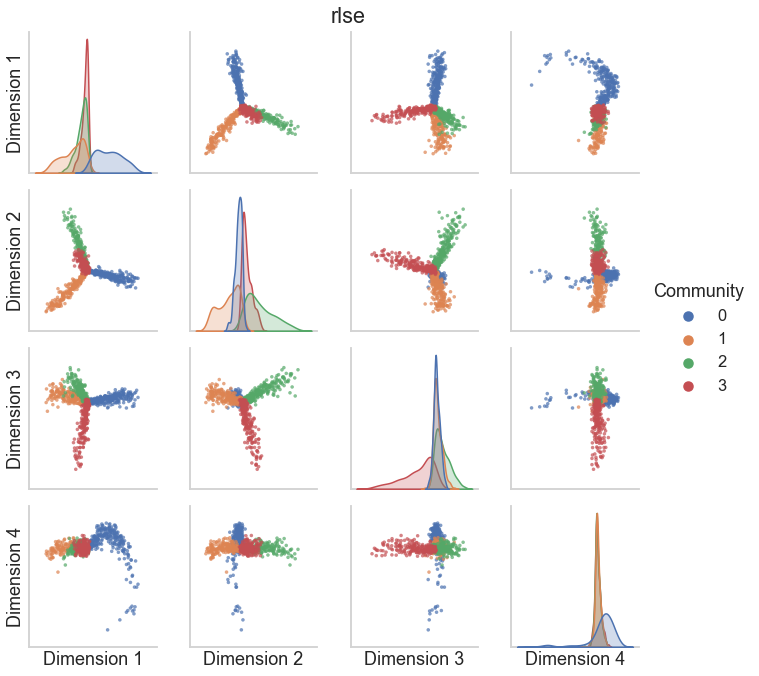

In [8]:
for method, embedding in embeddings.items():
    pairplot(
        embedding, labels=labels, palette=palette, legend_name="Community", title=method
    )


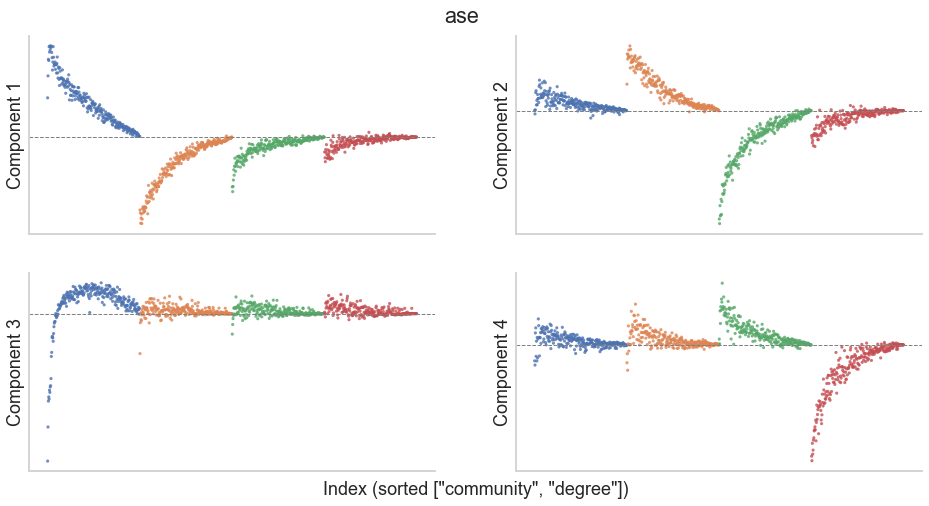

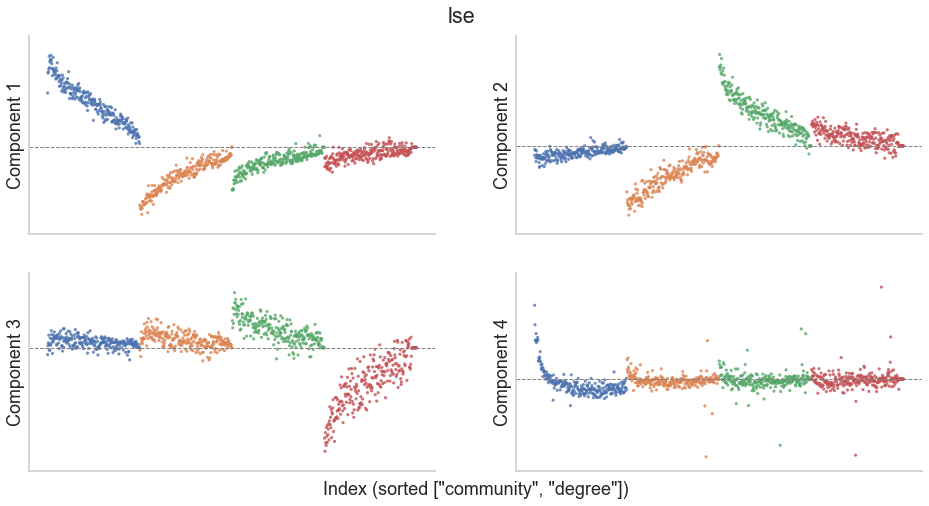

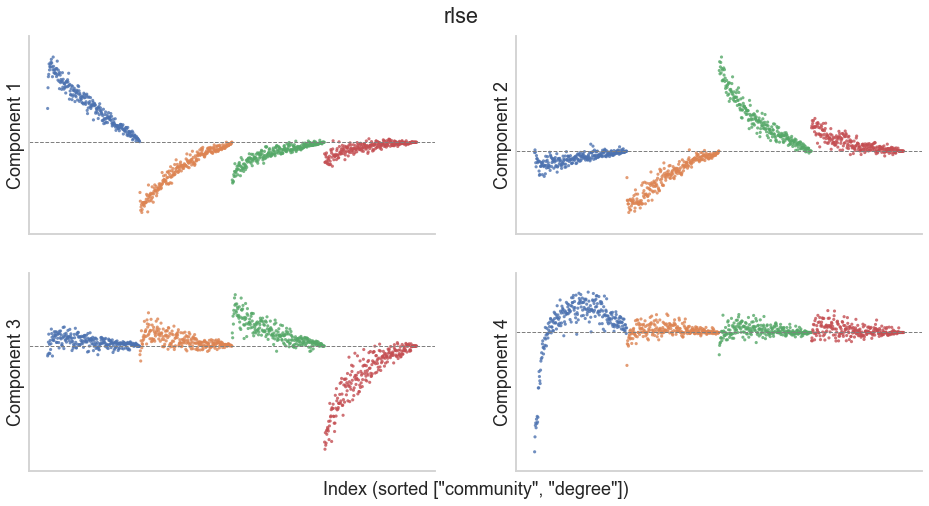

In [9]:
for method, plot_df in plot_dfs.items():
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    for i, ax in enumerate(axs.ravel()):
        sns.scatterplot(
            data=plot_df,
            x="ind",
            y=str(i),
            hue="label",
            ax=ax,
            legend=False,
            palette=palette,
            s=10,
            alpha=0.8,
            linewidth=0,
        )
        ax.set(xticks=[], yticks=[], xlabel="", ylabel=f"Component {i + 1}")
        ax.axhline(0, color="grey", linewidth=1, linestyle="--")
    axs[1, 0].set_xlabel('Index (sorted ["community", "degree"])', x=1.1, labelpad=10)
    fig.suptitle(method, y=0.93)



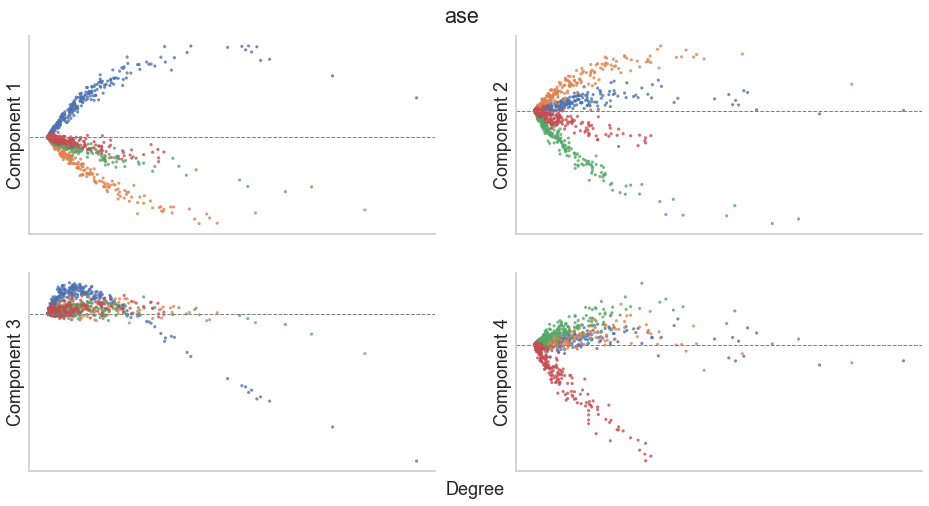

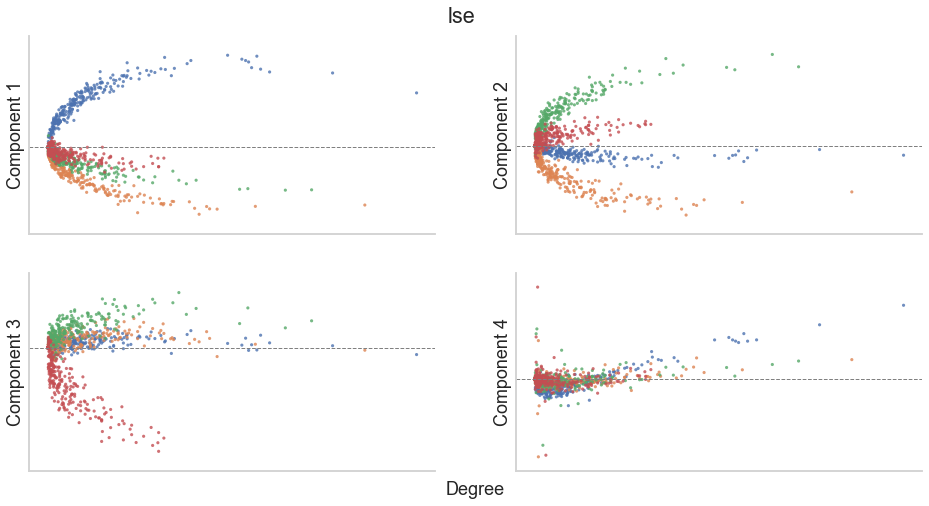

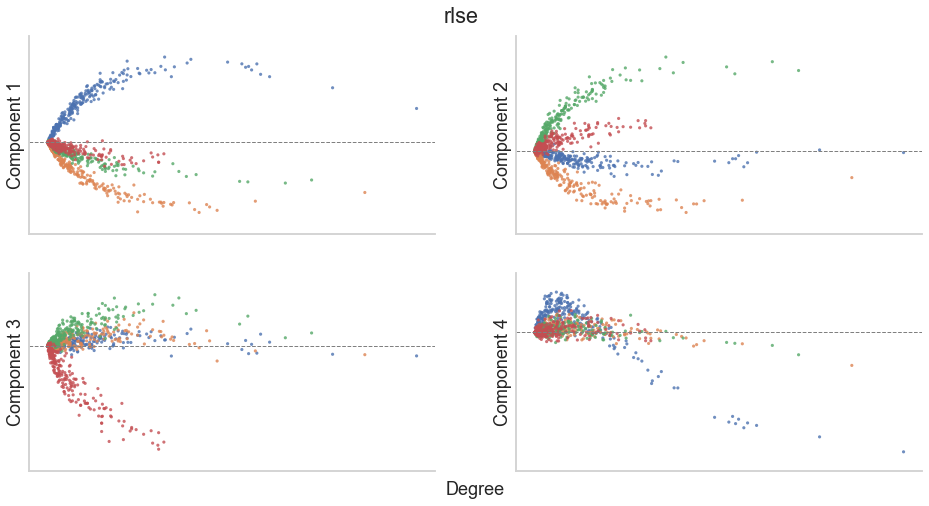

In [10]:
for method, plot_df in plot_dfs.items():
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    for i, ax in enumerate(axs.ravel()):
        sns.scatterplot(
            data=plot_df,
            x="degree",
            y=str(i),
            hue="label",
            ax=ax,
            legend=False,
            palette=palette,
            s=10,
            alpha=0.8,
            linewidth=0,
        )
        ax.set(xticks=[], yticks=[], xlabel="", ylabel=f"Component {i + 1}")
        ax.axhline(0, color="grey", linewidth=1, linestyle="--")
    fig.suptitle(method, y=0.93)
    axs[1, 0].set_xlabel("Degree", x=1.1, labelpad=10)
